#### Align ephys events to a master clock

**Choose session to analyze**

In [1]:
from pathlib import Path

In [2]:
input_root_dir = Path('/ceph/sjones/projects/FlexiVexi/behavioural_data')

# (Example session with both TTL and heartbeat events):
animal_ID = 'FNT103'
session_ID = '2024-07-31T10-21-59'

**Load recording**
* Load recording object
* Load continuous.dat from stream 'NI-DAQmx-103.PXIe-6341'

In [3]:
import os
from open_ephys.analysis import Session
import pandas as pd

def get_record_node_path(root_folder):
    # Traverse the directory tree
    for dirpath, dirnames, filenames in os.walk(root_folder):
        # Check if 'settings.xml' is in the current directory
        if 'settings.xml' in filenames:
            return dirpath
    return None

def get_session_path(root_folder):
    # Traverse the directory tree
    for dirpath, dirnames, filenames in os.walk(root_folder):
        # Check if any file ends with 'settings.xml'
        for filename in filenames:
            if filename.endswith('settings.xml'):
                # Get the folder one level up
                folder_one_level_up = os.path.dirname(dirpath)
                return folder_one_level_up
    return None

# Find the path to the recording session
session_folder = os.path.join(input_root_dir, animal_ID, session_ID)
ephys_session_path = get_session_path(session_folder)
print(ephys_session_path)

# load recording
session = Session(ephys_session_path)
recording = session.recordnodes[0].recordings[0]

# Get pandas data frame of continuous.dat on stream 'NI-DAQmx-103.PXIe-6341'
continuous_data = recording.continuous[1].get_samples(start_sample_index=0, end_sample_index=40000)
continuous_data = pd.DataFrame(continuous_data)
continuous_data

ModuleNotFoundError: No module named 'open_ephys'

In [5]:
# check whether events exist on line 4
events = recording.events

# get unique elements of stream_name
data_streams = list(set(events['stream_name']))

print(len(data_streams))
print(data_streams)

2
['PXIe-6341', 'ProbeA']


In [6]:
# check whether sync line can be added

# Sync line corresponding to heartbeat signal of ephys clock (1 pulse per second of duration 0.5 seconds). 
# Use this as the master clock (set main = True).
recording.add_sync_line(1,                          # 'Heartbeat' signal line number
                        100,                        # processor ID
                        'ProbeA',                   # stream name
                        main=True)                  # use as the main stream


# Sync line corresponding to TTL pulses
recording.add_sync_line(4,                          # TTL line number
                        103,                        # processor ID
                        'PXIe-6341',                # stream name
                        main=False)                 # synchronize to main stream

In [7]:
recording.compute_global_timestamps(overwrite=False)

Processor ID: 100, Stream Name: ProbeA, Line: 1 (main sync line))
  First event sample number: 111557
  Last event sample number: 97689097
  Total sync events: 3261
  Sample rate: 30000.0
Processor ID: 103, Stream Name: PXIe-6341, Line: 1 (aux sync line))
  First event sample number: 410439
  Last event sample number: 129483523
  Total sync events: 834
  Scale factor: 0.752926868148036
  Actual sample rate: 39844.507174767976


In [8]:
event_df = recording.events
event_df

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state,global_timestamp
0,1,157022,3.500025,103,1,PXIe-6341,1,-2.641582
1,1,111557,3.500029,100,0,ProbeA,1,3.718567
2,1,126557,4.000029,100,0,ProbeA,0,4.218567
3,1,177023,4.000050,103,1,PXIe-6341,0,-2.139606
4,1,197023,4.500050,103,1,PXIe-6341,1,-1.637655
...,...,...,...,...,...,...,...,...
14705,1,130518257,3262.530900,103,1,PXIe-6341,1,3269.107631
14706,1,97897211,3263.030722,100,0,ProbeA,0,3263.240367
14707,1,130538257,3263.030900,103,1,PXIe-6341,0,3269.609582
14708,1,97912211,3263.530724,100,0,ProbeA,1,3263.740367


In [9]:
TTL_pulses = event_df[(event_df['stream_name'] == 'PXIe-6341') & (event_df['line'] == 4)]
TTL_pulses = TTL_pulses.reset_index(drop=True)
TTL_pulses

# save the TTL pulses to a csv file
output_folder = session_output_folder
TTL_pulses.to_csv('TTL_pulses.csv', index=False)

(0.0, 50.0)

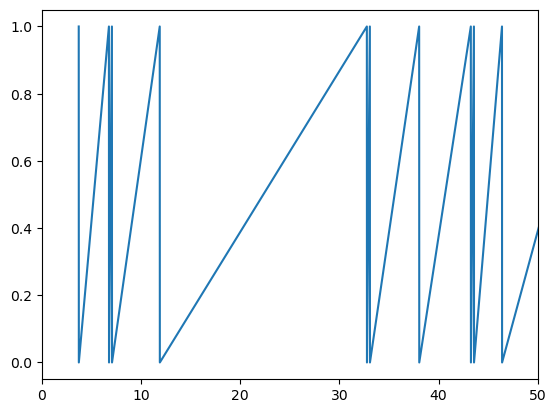

In [14]:
import matplotlib.pyplot as plt

plt.plot(TTL_pulses['global_timestamp'], TTL_pulses['state'])
plt.xlim(0, 50)